Import Libraries

In [1]:
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
# from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
import torch
import numpy as np
import random
import warnings
import shutil
import os

warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

In [2]:
# For reproducibility
seed = 27
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
import os
print(os.getcwd())
os.chdir(r'C:\Users\bryan\Downloads\ChestXrayDataset')
print(os.listdir())
print(os.getcwd())

c:\Users\bryan\Documents\AI (master)\Test Program\XAI alternative assessment
['checkpoint', 'chest_xray', 'chest_xray_new', 'samples']
C:\Users\bryan\Downloads\ChestXrayDataset


In [4]:
dataset_path = r'C:\Users\bryan\Downloads\ChestXrayDataset\chest_xray\\'

train_path = f'{dataset_path}/train/'
val_path = f'{dataset_path}/val/'
test_path = f'{dataset_path}/test/'

Samples of 4 pneumonia samples and 4 non-pneumonia samples

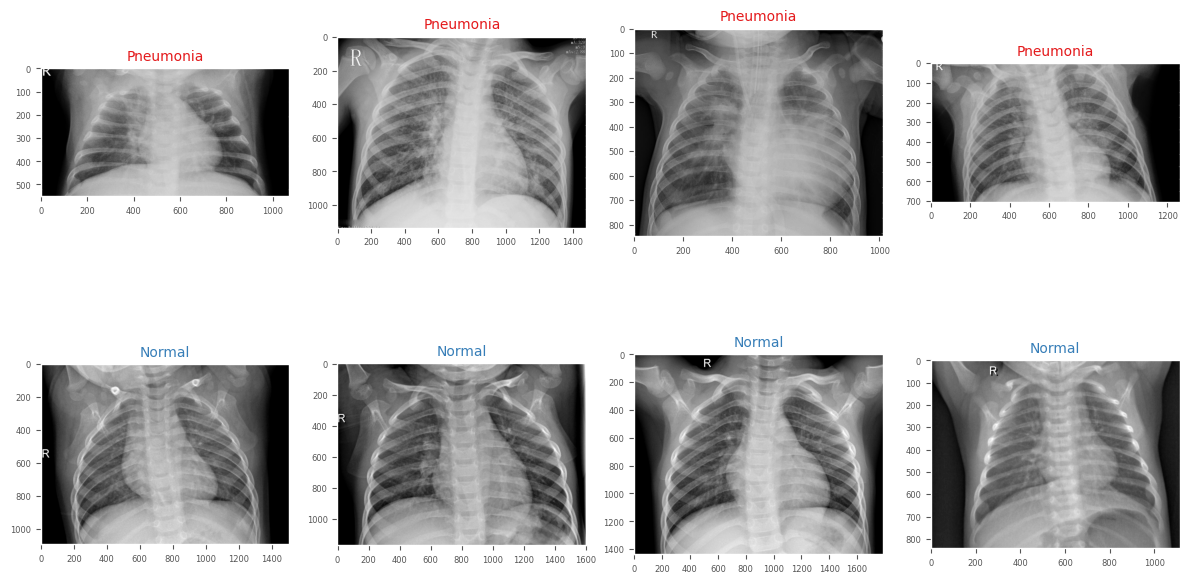

In [5]:
random_pneumonia_samples = random.sample(os.listdir(f'{train_path}/PNEUMONIA'), 4)
random_non_pneumonia_samples = random.sample(os.listdir(f'{train_path}/NORMAL'), 4)

plt.rcParams['axes.grid'] = False
colors = sns.color_palette('Set1', 2)
fig, ax = plt.subplots(2, 4, figsize=(12, 7))
ax = ax.flatten()

for i in range(4):
    filename = random_pneumonia_samples[i]
    image = Image.open(f'{train_path}/PNEUMONIA/{filename}')
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title('Pneumonia', color=colors[0], fontsize=10)
    ax[i].tick_params(axis='both', which='major', labelsize=6)

for i in range(4, 8):
    filename = random_non_pneumonia_samples[i-5]
    image = Image.open(f'{train_path}/NORMAL/{filename}')
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title('Normal', color=colors[1], fontsize=10)
    ax[i].tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.show()

Distribution of images across different categories (Normal vs. Pneumonia) in the training, validation, and test datasets

In [6]:
def plot_label_distribution(train_path: str, val_path: str, test_path: str) -> None:
    plt.rcParams['axes.grid'] = True
    train_counts = [len(os.listdir(f'{train_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    val_counts = [len(os.listdir(f'{val_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    test_counts = [len(os.listdir(f'{test_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    total_counts = [sum(x) for x in zip(train_counts, val_counts, test_counts)]

    total_train = sum(train_counts)
    total_val = sum(val_counts)
    total_test = sum(test_counts)
    total_images = sum(total_counts)

    fig, ax = plt.subplots(1, 4, figsize=(14, 5))
    bars0 = ax[0].bar(['Normal', 'Pneumonia'], train_counts, color=colors)
    ax[0].set_title('Train')
    ax[0].set_ylabel('Number of images')
    bars1 = ax[1].bar(['Normal', 'Pneumonia'], val_counts, color=colors)
    ax[1].set_title('Validation')
    bars2 = ax[2].bar(['Normal', 'Pneumonia'], test_counts, color=colors)
    ax[2].set_title('Test')
    bars3 = ax[3].bar(['Normal', 'Pneumonia'], total_counts, color=colors)
    ax[3].set_title('Total')

    def add_labels(bars, ax, total):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height,
                    f'{height} ({height / total:.1%})',
                    ha='center', va='bottom')

    add_labels(bars0, ax[0], total_train)
    add_labels(bars1, ax[1], total_val)
    add_labels(bars2, ax[2], total_test)
    add_labels(bars3, ax[3], total_images)

    plt.tight_layout()
    plt.show()

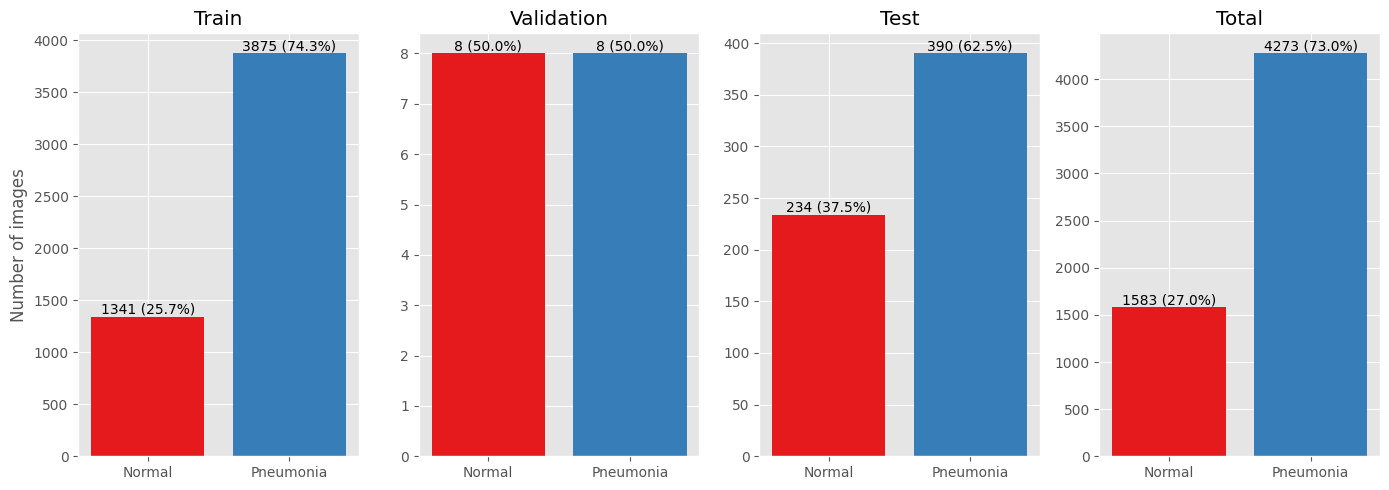

In [7]:
plot_label_distribution(train_path, val_path, test_path)

Data Preparation & Preprocessing

1) The dataset is not split evenly for Train, Validation and Testing. Code below combines all the images and resplit the images to Training, Validation, and Testing with pereentage 80%, 20%, 20% respectively.

In [9]:
new_dataset_path = r'C:\Users\bryan\Downloads\ChestXrayDataset\chest_xray_new'

new_train_path = f'{new_dataset_path}/train/'
new_val_path = f'{new_dataset_path}/val/'
new_test_path = f'{new_dataset_path}/test/'

if not os.path.exists(new_dataset_path):

    # Create New Directories:
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)

    # Collect All Files
    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = f'{dataset_path}/{split}/{cls}'
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])
        
        random.shuffle(all_files)
        
        train_files = all_files[:int(len(all_files)*0.8)] #The first 80% of the files are assigned to the training set.
        val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)] # The next 10% of the files are assigned to the validation set.
        test_files = all_files[int(len(all_files)*0.9):] #The remaining 10% of the files are assigned to the test set.
        
        # Copy Files to New Directories
        for file, source_folder in train_files:
            dest = f'{new_dataset_path}/train/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)
        
        for file, source_folder in val_files:
            dest = f'{new_dataset_path}/val/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)
        
        for file, source_folder in test_files:
            dest = f'{new_dataset_path}/test/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)    

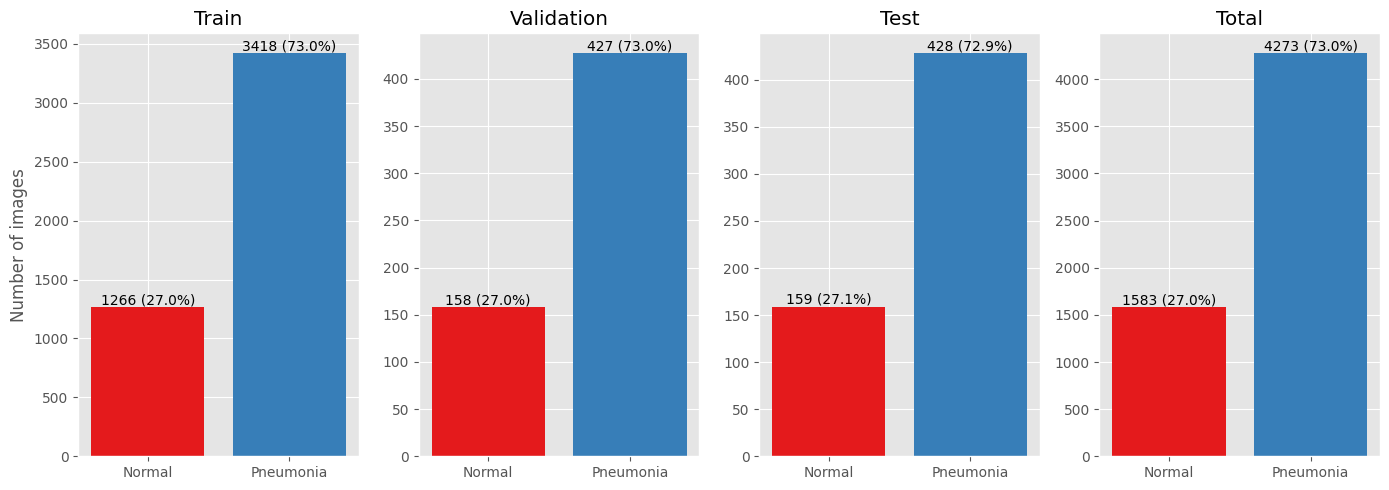

In [10]:
# Plot the evenly distributed dataset
plot_label_distribution(new_train_path, new_val_path, new_test_path)

In [11]:
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 16
NUM_WORKERS = 4
DATA_TYPES = ['train', 'val', 'test']

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(new_dataset_path, x), data_transforms[x]) for x in DATA_TYPES}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in DATA_TYPES}
dataset_sizes = {x: len(image_datasets[x]) for x in DATA_TYPES}
class_names = image_datasets['train'].classes



In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print("✅ CUDA is available. Using GPU.")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0)} bytes")
else:
    print("⚠️ CUDA is not available. Using CPU instead.")


✅ CUDA is available. Using GPU.
CUDA version: 12.4
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
GPU Memory Allocated: 0 bytes
GPU Memory Cached: 0 bytes


In [17]:
class Trainer:
    def __init__(
        self,
        device: str,
        model: torch.nn.Module,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        test_dataloader: DataLoader,
        checkpoint_path: str,
     
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_accuracy = 0.0
        self.best_model_path = None

    def train(self, current_epoch_nr: int,) -> Tuple[float, float]:
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0
        
      

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device), y.to(self.device)

            self.optimizer.zero_grad()

            y_hat = self.model(x)            
            _, preds = torch.max(y_hat, 1)
            loss = self.criterion(y_hat, y)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            n_corrects += torch.sum(preds == y.data).data.item()
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_acc=round(n_corrects / total, 5),
                             train_loss=round(running_loss / total, 5))
            
        self.scheduler.step()

        train_accuracy = n_corrects / total
        train_loss = running_loss / num_batches

        return train_accuracy, train_loss

    def evaluate(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                self.optimizer.zero_grad()

                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)
                

                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_acc=round(n_corrects / total, 5),
                                 val_loss=round(running_loss / total, 5))

        val_accuracy = n_corrects / total
        val_loss = running_loss / num_batches

   
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            checkpoint_name = f'epoch_{current_epoch_nr}_acc_{round(val_accuracy, 2)}.pth'
            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(self.checkpoint_path, checkpoint_name)

        return val_accuracy, val_loss

    def test(self) -> Tuple[float, float, list, list, models.resnet.ResNet]:
        self.model.eval()

        num_batches = len(self.test_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0
        
        targets = []
        predictions = []

        with torch.no_grad():
            loop = tqdm(self.test_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                y_hat = self.model(x)                
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)
                
                targets.extend(y.cpu().numpy())
                predictions.extend(preds.cpu().numpy())

                loop.set_description('Testing')
                loop.set_postfix(test_acc=round(n_corrects / total, 5),
                                 test_loss=round(running_loss / total, 5))

        test_accuracy = n_corrects / total
        test_loss = running_loss / num_batches
        
        print('\nTest Accuracy: ', test_accuracy)
        print('Test Loss: ', test_loss)

        self.model.load_state_dict(torch.load(self.best_model_path))
        
        return test_accuracy, test_loss, targets, predictions, self.model
    

Pretrained InceptionV3 Model

In [14]:
model = models.inception_v3()
n_features = model.fc.in_features
model.fc = nn.Linear(n_features, len(class_names))
model.aux_logits = False
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
max_epochs = 10

train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
test_dataloader = dataloaders['test']

checkpoint_path = r'C:\Users\bryan\Downloads\ChestXrayDataset\checkpoint'
try:
    os.mkdir(checkpoint_path)
except FileExistsError:
    pass


trainer = Trainer(
    device=device,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    checkpoint_path=checkpoint_path,
)

histories = []
for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = trainer.train(current_epoch_nr=epoch)
    val_acc, val_loss = trainer.evaluate(current_epoch_nr=epoch)
    
    histories.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

test_acc, test_loss, targets, predictions, best_model = trainer.test()

Testing: 100%|██████████| 37/37 [00:13<00:00,  2.66it/s, test_acc=0.973, test_loss=0.0831]



Test Accuracy:  0.9727427597955707
Test Loss:  1.3188211562967784


Analyse the Results

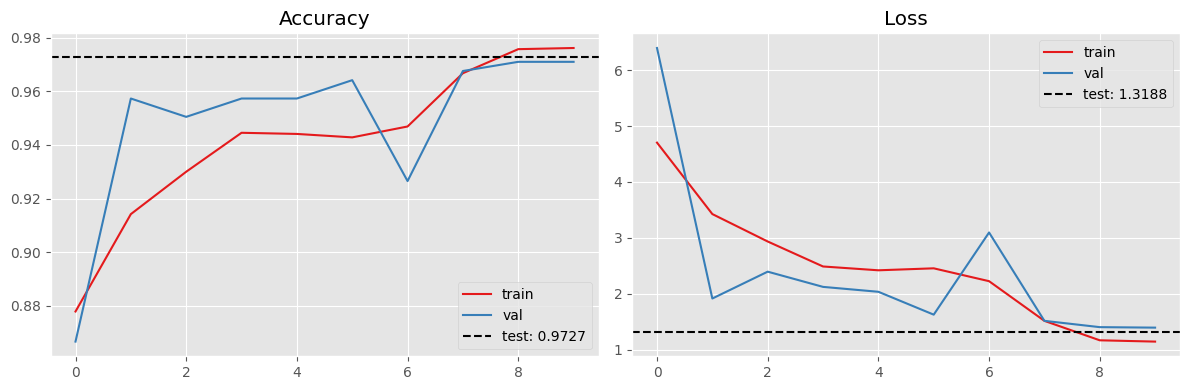

In [19]:
train_accs = [x['train_acc'] for x in histories]
train_losses = [x['train_loss'] for x in histories]
val_accs = [x['val_acc'] for x in histories]
val_losses = [x['val_loss'] for x in histories]

plt.rcParams['axes.grid'] = True
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='train', color=colors[0])
plt.plot(val_accs, label='val', color=colors[1])
plt.axhline(y=test_acc, color='black', linestyle='--', label=f'test: {test_acc:.4f}')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='train', color=colors[0])
plt.plot(val_losses, label='val', color=colors[1])
plt.axhline(y=test_loss, color='black', linestyle='--', label=f'test: {test_loss:.4f}')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

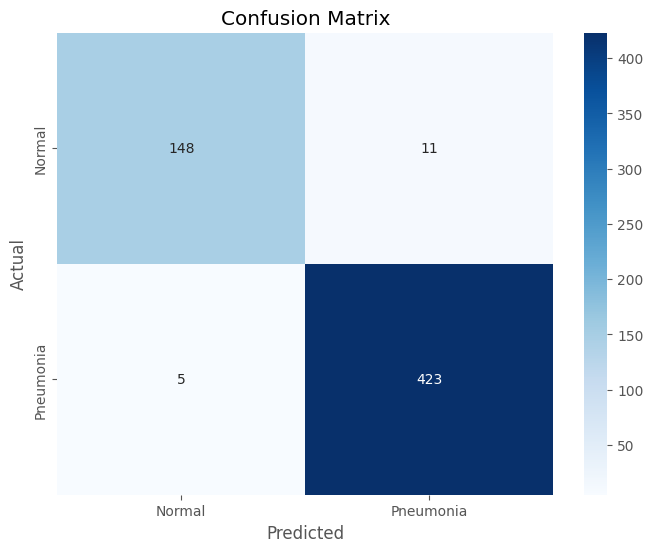

In [20]:
cm = confusion_matrix(targets, predictions)

plt.rcParams['axes.grid'] = False
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
print(classification_report(targets, predictions, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.97      0.93      0.95       159
   Pneumonia       0.97      0.99      0.98       428

    accuracy                           0.97       587
   macro avg       0.97      0.96      0.97       587
weighted avg       0.97      0.97      0.97       587



Pretrained Densenet121

In [28]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_WORKERS = 4
DATA_TYPES = ['train', 'val', 'test']

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(new_dataset_path, x), data_transforms[x]) for x in DATA_TYPES}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in DATA_TYPES}
dataset_sizes = {x: len(image_datasets[x]) for x in DATA_TYPES}
class_names = image_datasets['train'].classes



In [ ]:

# Load pretrained DenseNet
densenet_model = models.densenet121(pretrained=True)

# Modify the classifier for binary classification (Normal vs Pneumonia)
num_features = densenet_model.classifier.in_features
densenet_model.classifier = nn.Sequential(
    nn.Linear(num_features, 2),  # 2 classes: Normal, Pneumonia
)

densenet_model = densenet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(densenet_model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [34]:
max_epochs = 10

train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
test_dataloader = dataloaders['test']

checkpoint_path = r'C:\Users\bryan\Downloads\ChestXrayDataset\checkpoint'
try:
    os.mkdir(checkpoint_path)
except FileExistsError:
    pass

trainer = Trainer(
    device=device,
    model=densenet_model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    checkpoint_path=checkpoint_path,
)


histories = []
for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = trainer.train(current_epoch_nr=epoch)
    val_acc, val_loss = trainer.evaluate(current_epoch_nr=epoch)
    
    histories.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

test_acc, test_loss, targets, predictions, best_model = trainer.test()

Testing: 100%|██████████| 19/19 [00:13<00:00,  1.36it/s, test_acc=0.971, test_loss=0.0737]



Test Accuracy:  0.9710391822827938
Test Loss:  2.2780812520619578


In [47]:
# Assuming `model` is your trained model
torch.save(densenet_model.state_dict(), 'densenet_model.pth')

In [79]:
densenet_model = densenet_model.to('cpu')

In [148]:
model_densenet121_layers = densenet_model.features[-1] #target layer for visualization

In [81]:
model_densenet121_layers

BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [155]:
img_path= r'C:\Users\bryan\Downloads\ChestXrayDataset\chest_xray_new\test\PNEUMONIA\person16_bacteria_55.jpeg'

# img_path= r'C:\Users\bryan\Downloads\ChestXrayDataset\chest_xray_new\test\NORMAL\IM-0043-0001.jpeg'
# person14_bacteria_51, person16_bacteria_55, person20_bacteria_69

# normal: IM-0043-0001, IM-0046-0001
# 'C:\Users\bryan\Downloads\ChestXrayDataset\chest_xray_new\test\PNEUMONIA'

# img_path = new_test_path + 'PNEUMONIA/person1_virus_9.jpeg'

In [151]:
img_path

'C:\\Users\\bryan\\Downloads\\ChestXrayDataset\\chest_xray_new\\test\\NORMAL\\IM-0043-0001.jpeg'

In [156]:
import sys
sys.path.append('C:\\Users\\bryan\\Documents\\AI (master)\\Test Program\\XAI alternative assessment')
from gradcam1 import GradCAM

gradcam = GradCAM(densenet_model, model_densenet121_layers, img_path)

In [157]:
img, heatmap, result, index = gradcam()

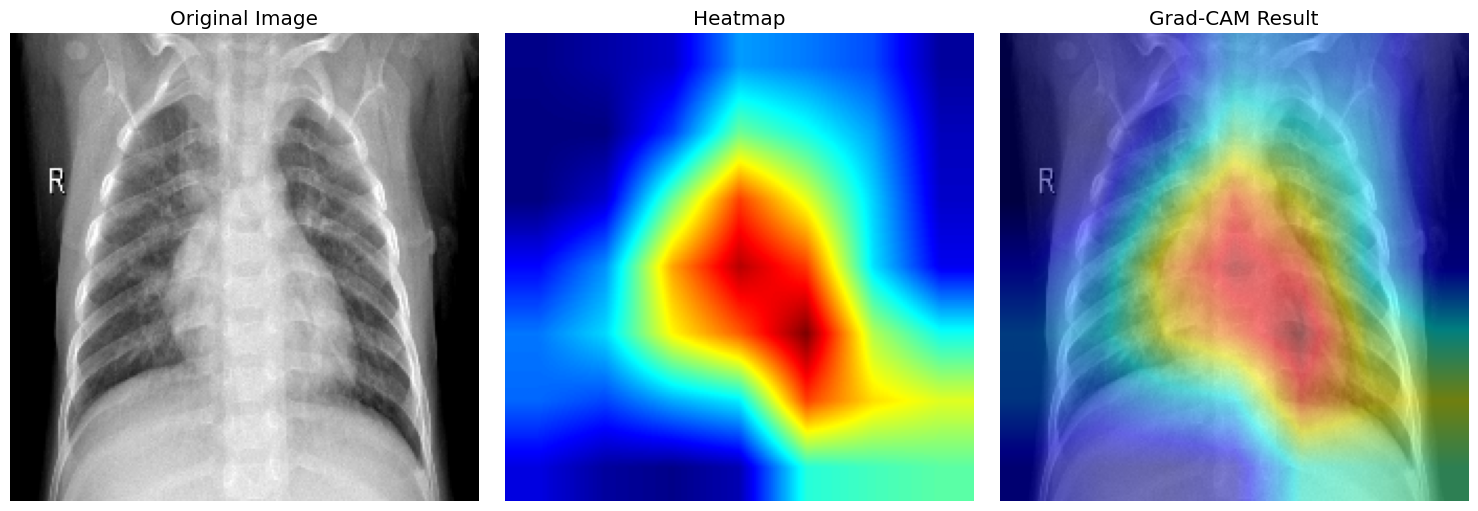

In [158]:
import matplotlib.pyplot as plt

# Plot the images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Display original image
ax[0].imshow(img.permute(1, 2, 0).cpu().numpy())
ax[0].set_title("Original Image")
ax[0].axis("off")

# Display heatmap
ax[1].imshow(heatmap.permute(1, 2, 0).cpu().numpy(), cmap="jet")
ax[1].set_title("Heatmap")
ax[1].axis("off")

# Display overlayed result
ax[2].imshow(result.permute(1, 2, 0).cpu().numpy())
ax[2].set_title("Grad-CAM Result")
ax[2].axis("off")

plt.tight_layout()
plt.show()

LIME / SHAP

In [165]:
import lime
from lime import lime_image
import numpy as np
import torch
from torch import nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Function to load and preprocess the image
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert("RGB")
    return transform(img).unsqueeze(0)  # Add batch dimension

# Function to predict using the model (wrapper for LIME)
def predict_fn(images):
    images = torch.Tensor(images)  # Ensure data is in the right format
    # Convert LIME format (H, W, C) to PyTorch format (C, H, W)
    images = images.permute(0, 3, 1, 2)  # Convert from (batch, height, width, channels) to (batch, channels, height, width)
    
    with torch.no_grad():
        outputs = densenet_model(images)
    
    # Softmax to get probabilities instead of raw logits
    probs = torch.nn.functional.softmax(outputs, dim=1)
    
    return probs.detach().cpu().numpy()

# Load the image you want to explain
img_path = r'C:\Users\bryan\Downloads\ChestXrayDataset\chest_xray_new\test\PNEUMONIA\person14_bacteria_51.jpeg'
input_image = preprocess_image(img_path)

# Convert the image from PyTorch format (C, H, W) to (H, W, C) for LIME
input_image_np = input_image.squeeze().permute(1, 2, 0).cpu().numpy()

# LIME expects the shape of the image to be (1, height, width, channels), not (height, width, channels)
input_image_np = np.expand_dims(input_image_np, axis=0)  # Add batch dimension

# Create a LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Explain the instance (this might take some time depending on the number of samples)
# Now input_image_np is in the correct shape: (1, 224, 224, 3)
explanation = explainer.explain_instance(input_image_np[0], predict_fn, top_labels=1, num_samples=1000)



# Optionally, save the explanation plot
# plt.imsave("lime_explanation.png", explanation_img[0])

100%|██████████| 1000/1000 [00:48<00:00, 20.79it/s]


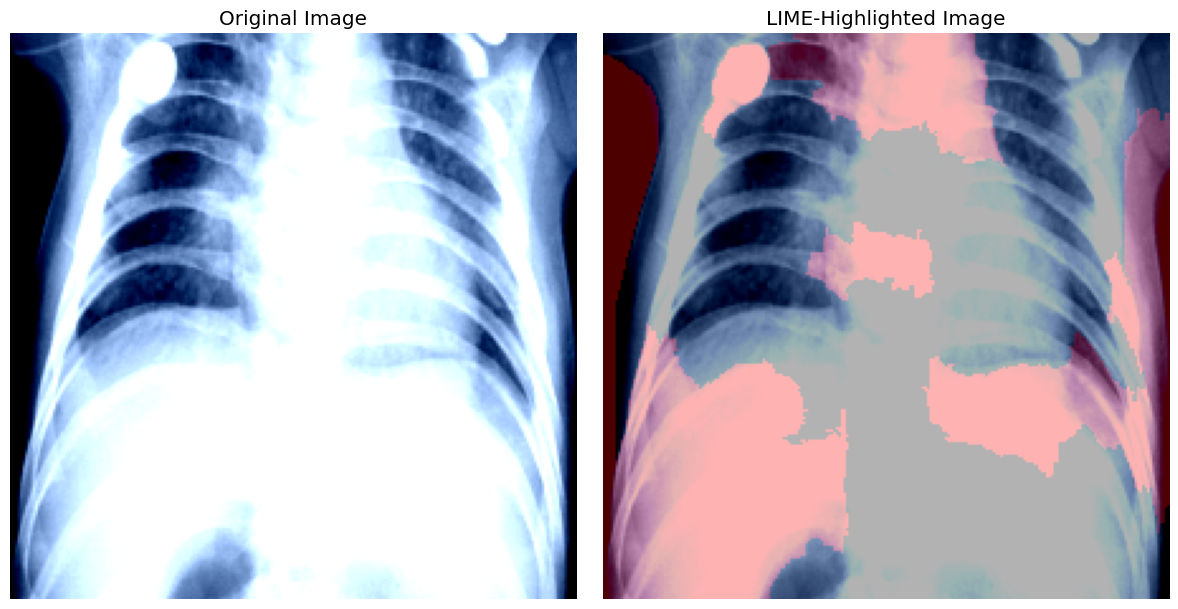

In [166]:
# Get the explanation image and mask
explanation_img, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=10, hide_rest=False)

# Ensure the mask is binary (mask contains True/False values)
mask = mask.astype(bool)

# Create a red mask where the highlighted areas will be red (RGB: [1, 0, 0])
red_mask = np.zeros_like(explanation_img)  # Shape: (height, width, 3)
red_mask[mask] = [1, 0, 0]  # Set the mask areas to red (RGB: [1, 0, 0])

# Normalize explanation_img to be in the range [0, 1]
explanation_img = np.clip(explanation_img, 0, 1)

# Blend the original image with the red mask (you can adjust the intensity if needed)
highlighted_image = explanation_img * 0.7 + red_mask * 0.3  # Control blending strength

# Display the original image and the LIME-explained image side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
axes[0].imshow(explanation_img)
axes[0].axis('off')
axes[0].set_title('Original Image')

# Display the LIME-explained image
axes[1].imshow(highlighted_image)
axes[1].axis('off')
axes[1].set_title('LIME-Highlighted Image')

plt.tight_layout()
plt.show()

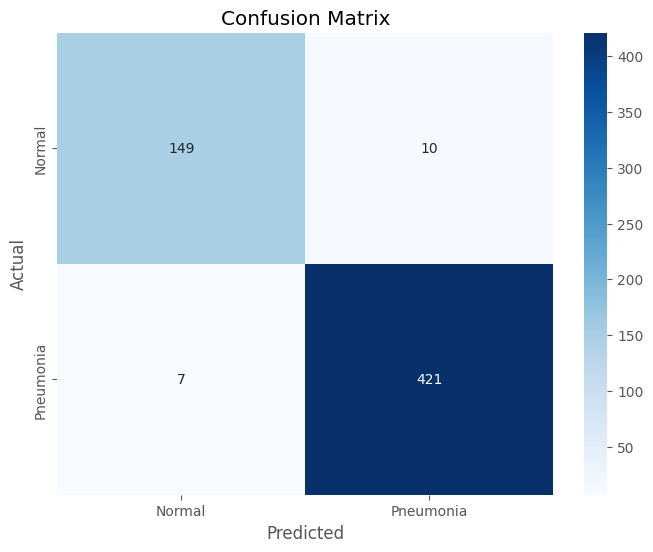

In [89]:
cm = confusion_matrix(targets, predictions)

plt.rcParams['axes.grid'] = False
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [90]:
print(classification_report(targets, predictions, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.96      0.94      0.95       159
   Pneumonia       0.98      0.98      0.98       428

    accuracy                           0.97       587
   macro avg       0.97      0.96      0.96       587
weighted avg       0.97      0.97      0.97       587



PreTrained VGG16 Model

In [27]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_WORKERS = 4
DATA_TYPES = ['train', 'val', 'test']

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(new_dataset_path, x), data_transforms[x]) for x in DATA_TYPES}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in DATA_TYPES}
dataset_sizes = {x: len(image_datasets[x]) for x in DATA_TYPES}
class_names = image_datasets['train'].classes



In [15]:
# Load the pretrained VGG16 model
vgg16_model = models.vgg16(pretrained=True)

vgg16_model.classifier[6] = nn.Linear(4096, 2)  

# Freeze the convolutional layers
for param in vgg16_model.features.parameters():
    param.requires_grad = False

vgg16_model = vgg16_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vgg16_model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
max_epochs = 10

train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
test_dataloader = dataloaders['test']

checkpoint_path = r'C:\Users\bryan\Downloads\ChestXrayDataset\checkpoint'
try:
    os.mkdir(checkpoint_path)
except FileExistsError:
    pass

target_layer = vgg16_model.features[29]

trainer = Trainer(
    device=device,
    model=vgg16_model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    checkpoint_path=checkpoint_path,
    pneumonia_samples=pneumonia_samples,
)


histories = []
for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = trainer.train(current_epoch_nr=epoch)
    val_acc, val_loss = trainer.evaluate(current_epoch_nr=epoch)
    
    histories.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

test_acc, test_loss, targets, predictions, best_model = trainer.test()

Testing: 100%|██████████| 19/19 [00:09<00:00,  1.94it/s, test_acc=0.971, test_loss=0.088] 



Test Accuracy:  0.9710391822827938
Test Loss:  2.718793954112028


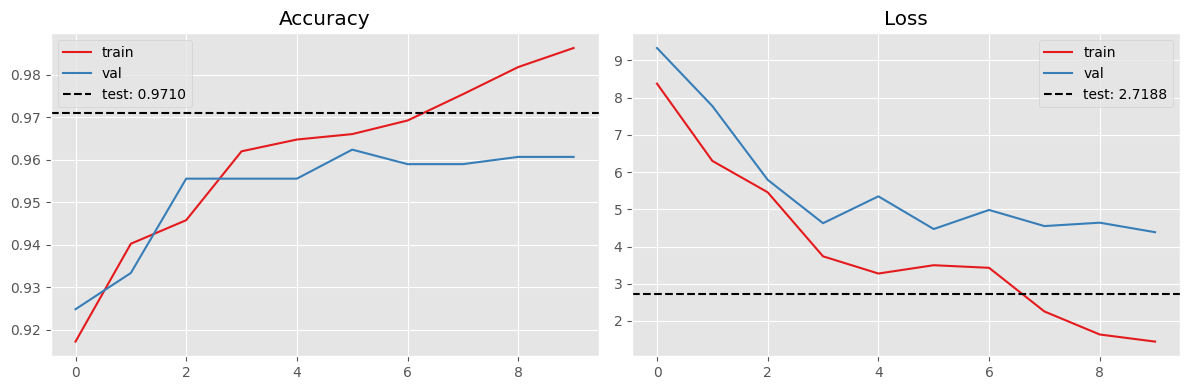

In [17]:
train_accs = [x['train_acc'] for x in histories]
train_losses = [x['train_loss'] for x in histories]
val_accs = [x['val_acc'] for x in histories]
val_losses = [x['val_loss'] for x in histories]

plt.rcParams['axes.grid'] = True
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='train', color=colors[0])
plt.plot(val_accs, label='val', color=colors[1])
plt.axhline(y=test_acc, color='black', linestyle='--', label=f'test: {test_acc:.4f}')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='train', color=colors[0])
plt.plot(val_losses, label='val', color=colors[1])
plt.axhline(y=test_loss, color='black', linestyle='--', label=f'test: {test_loss:.4f}')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

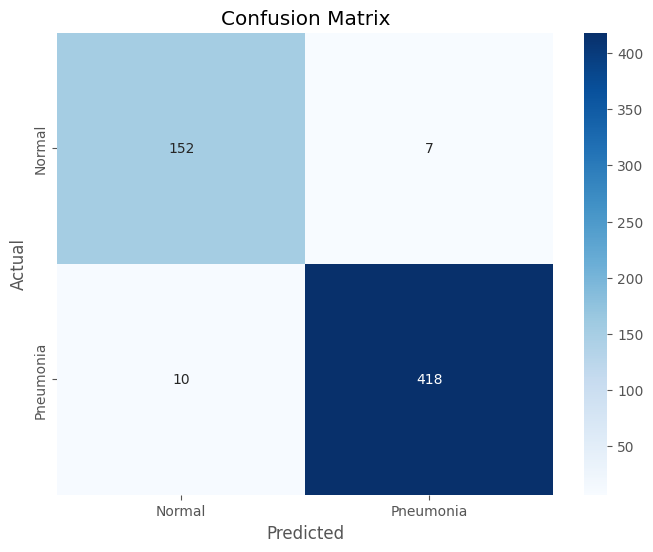

In [18]:
cm = confusion_matrix(targets, predictions)

plt.rcParams['axes.grid'] = False
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
print(classification_report(targets, predictions, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.94      0.96      0.95       159
   Pneumonia       0.98      0.98      0.98       428

    accuracy                           0.97       587
   macro avg       0.96      0.97      0.96       587
weighted avg       0.97      0.97      0.97       587



PreTrained ResNet18 Model

In [49]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_WORKERS = 4
DATA_TYPES = ['train', 'val', 'test']

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(new_dataset_path, x), data_transforms[x]) for x in DATA_TYPES}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in DATA_TYPES}
dataset_sizes = {x: len(image_datasets[x]) for x in DATA_TYPES}
class_names = image_datasets['train'].classes



In [50]:
# Load ResNet18 pretrained model
resnet18_model = models.resnet18(pretrained=True)

# Adjust the final layer for 3 classes
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 3)

# Move model to the appropriate device (GPU or CPU)
resnet18_model = resnet18_model.to(device)

# Freeze all layers except the final fully connected layer
for param in resnet18_model.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze the final fully connected layer
for param in resnet18_model.fc.parameters():
    param.requires_grad = True  # Unfreeze the last layer

# Print the model to verify the layers and their requires_grad status
for name, param in resnet18_model.named_parameters():
    print(f"{name}: {param.requires_grad}")


conv1.weight: False
bn1.weight: False
bn1.bias: False
layer1.0.conv1.weight: False
layer1.0.bn1.weight: False
layer1.0.bn1.bias: False
layer1.0.conv2.weight: False
layer1.0.bn2.weight: False
layer1.0.bn2.bias: False
layer1.1.conv1.weight: False
layer1.1.bn1.weight: False
layer1.1.bn1.bias: False
layer1.1.conv2.weight: False
layer1.1.bn2.weight: False
layer1.1.bn2.bias: False
layer2.0.conv1.weight: False
layer2.0.bn1.weight: False
layer2.0.bn1.bias: False
layer2.0.conv2.weight: False
layer2.0.bn2.weight: False
layer2.0.bn2.bias: False
layer2.0.downsample.0.weight: False
layer2.0.downsample.1.weight: False
layer2.0.downsample.1.bias: False
layer2.1.conv1.weight: False
layer2.1.bn1.weight: False
layer2.1.bn1.bias: False
layer2.1.conv2.weight: False
layer2.1.bn2.weight: False
layer2.1.bn2.bias: False
layer3.0.conv1.weight: False
layer3.0.bn1.weight: False
layer3.0.bn1.bias: False
layer3.0.conv2.weight: False
layer3.0.bn2.weight: False
layer3.0.bn2.bias: False
layer3.0.downsample.0.weight: 

In [51]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet18_model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [52]:
max_epochs = 10

train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
test_dataloader = dataloaders['test']

checkpoint_path = r'C:\Users\bryan\Downloads\ChestXrayDataset\checkpoint'
try:
    os.mkdir(checkpoint_path)
except FileExistsError:
    pass


trainer = Trainer(
    device=device,
    model=resnet18_model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    checkpoint_path=checkpoint_path,
    pneumonia_samples=pneumonia_samples
)

histories = []
for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = trainer.train(current_epoch_nr=epoch)
    val_acc, val_loss = trainer.evaluate(current_epoch_nr=epoch)
    
    histories.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

test_acc, test_loss, targets, predictions, best_model = trainer.test()

Testing: 100%|██████████| 19/19 [00:29<00:00,  1.53s/it, test_acc=0.934, test_loss=0.176]


Test Accuracy:  0.9335604770017035
Test Loss:  5.44969875992913


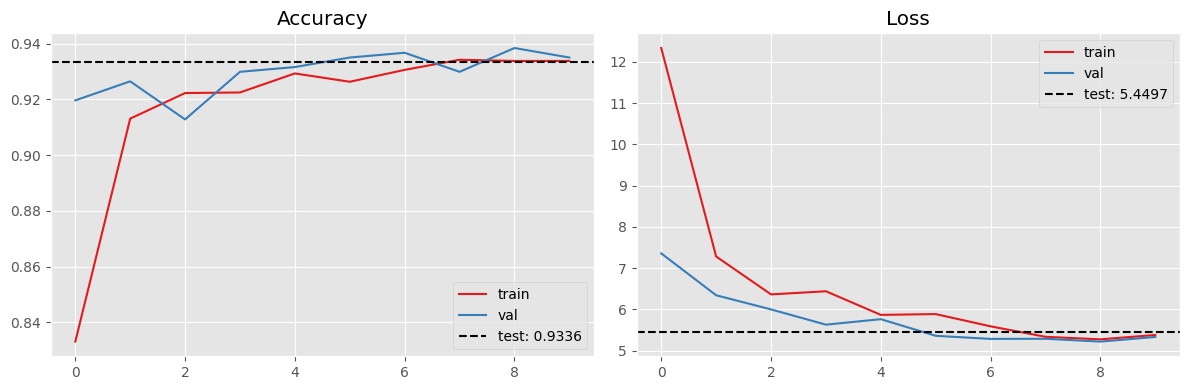

In [53]:
train_accs = [x['train_acc'] for x in histories]
train_losses = [x['train_loss'] for x in histories]
val_accs = [x['val_acc'] for x in histories]
val_losses = [x['val_loss'] for x in histories]

plt.rcParams['axes.grid'] = True
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='train', color=colors[0])
plt.plot(val_accs, label='val', color=colors[1])
plt.axhline(y=test_acc, color='black', linestyle='--', label=f'test: {test_acc:.4f}')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='train', color=colors[0])
plt.plot(val_losses, label='val', color=colors[1])
plt.axhline(y=test_loss, color='black', linestyle='--', label=f'test: {test_loss:.4f}')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

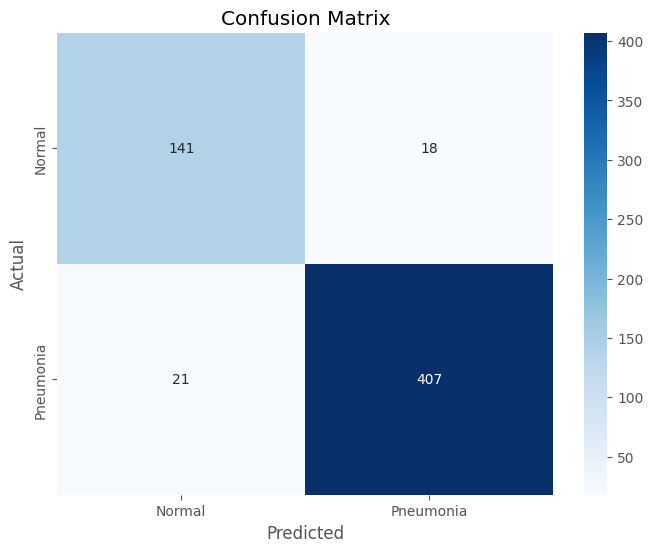

In [54]:
cm = confusion_matrix(targets, predictions)

plt.rcParams['axes.grid'] = False
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [55]:
print(classification_report(targets, predictions, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.87      0.89      0.88       159
   Pneumonia       0.96      0.95      0.95       428

    accuracy                           0.93       587
   macro avg       0.91      0.92      0.92       587
weighted avg       0.93      0.93      0.93       587

